# CNN Cancer Detection Kaggle Mini-Project

# Problem Statement

This is a binary image classification problem. Where we will use a Convolution Neural Network to identify metastatic cancer in images taken from digital pathology scans.

We are using a dataset found on Kaggle located [here](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

Before running this project please download the data and extract it into a directory called data/

The dataset for the Histopathologic Cancer Detection competition on Kaggle includes images and CSV files for classification. It contains approximately 220,025 96x96 pixel images of histopathologic scans in TIFF format, each labeled with either 0 (non-cancerous) or 1 (cancerous). The images are organized in folders, and a CSV file provides the labels. This dataset is structured for binary classification tasks and is designed for training machine learning models to detect cancer in histopathologic images.

# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import random_split
from torchsummary import summary

from PIL import Image
from PIL import Image, ImageDraw

import random
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Using CUDA
torch.cuda.is_available()

True

# Define paths and variables

In [2]:
# Setting random seeds for reproducibility, 42 is tradition
torch.manual_seed(42)
np.random.seed(42)

# Define paths to the directories containing the train and test datasets
train_dir = 'data/train'
test_dir = 'data/test'
train_labels = pd.read_csv('data/train_labels.csv')

# Exploratory Data Analysis (EDA)

## Basic information

In [3]:
print(train_labels.info())
print(train_labels.head().to_markdown())
train_labels.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


(220025, 2)

## Histogram of labels


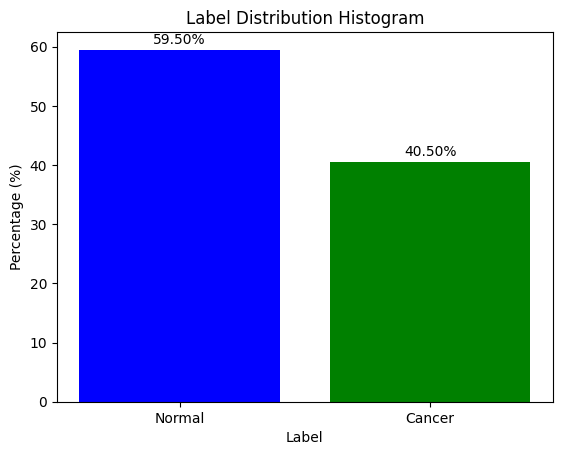

In [4]:
# Calculate the distribution and percentage of the label column (0s and 1s)
label_counts = train_labels['label'].value_counts()
total_count = len(train_labels)
percentages = (label_counts / total_count) * 100

# Plot the histogram for label distribution with percentages
plt.bar(label_counts.index, percentages.values, color=['b', 'g'])
plt.xticks([0, 1], ['Normal', 'Cancer'])
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.title('Label Distribution Histogram')

# Annotate the percentage on top of the bars
for i, value in enumerate(percentages.values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center')

plt.show()

## Cleaning procedure

Our cleaning efforts consists of checking for for non jpg in the dataset, non were found.

## Display positive and negative sample images

In [84]:
normal = train_labels.loc[train_labels['label']==0]['id'].values[:3]      
cancer = train_labels.loc[train_labels['label']==1]['id'].values[:3]    

def display_image_set(image_ids, title, image_directory=train_dir):
    """
    Displays a set of images with a white rectangular outline.

    Parameters:
        image_ids (list of str): List of image IDs to display.
        title (str): Title for the displayed images.
        image_directory (str): Directory where the images are located.
    """
    for image_id in image_ids:
        # Construct the full path for the image file
        image_path = os.path.join(image_directory, f"{image_id}.tif")
        
        # Open and prepare the image
        image = Image.open(image_path).convert("RGBA")
        
        # Draw a white rectangle outline around the image
        draw = ImageDraw.Draw(image)
        draw.rectangle(((0, 0), (95, 95)), outline='white')
        
        # Display the image
        plt.figure(figsize=(3, 5))
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.title(image_path)
        plt.show()

## Cancer Negative

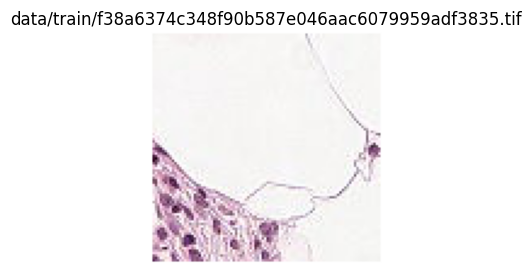

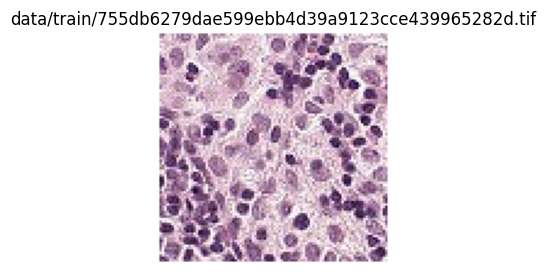

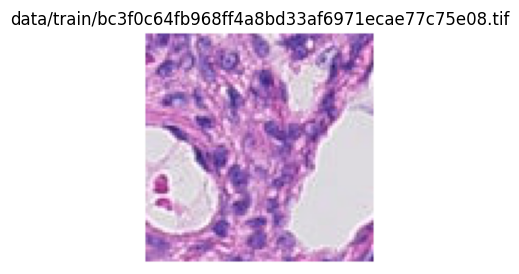

In [85]:
display_image_set(normal,'Negative')

## Cancer Positive

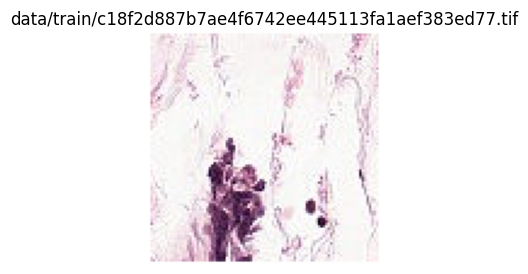

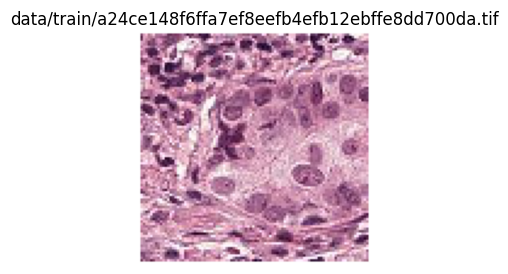

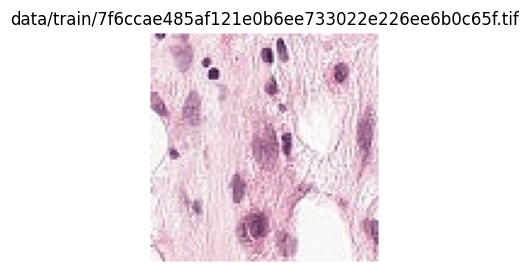

In [87]:
display_image_set(cancer,'Positive')

# Plan of Analysis

Based on the exploratory data analysis (EDA), we will resize and normalize the images by standardizing the image channels. This involves subtracting the dataset's mean and dividing by its standard deviation for each RGB channel.

To begin, we will create datasets for the data loaders—one for the training and validation sets, and another for the test set.

Next, we calculate the mean and standard deviation of the RGB values from the dataset, which will be used in the transformation pipeline.

We will then define a transformation pipeline that will be applied to the images before they are input into the model. This pipeline includes the following steps:

1. **RandomRotation**: The images are randomly rotated by up to 15 degrees. This adds further variety to the training data, helping the model generalize across various object orientations.

2. **ToTensor**: The images are converted to PyTorch tensors, which is the required format for deep learning models in PyTorch. Tensors facilitate efficient manipulation of numerical data for the training process.

3. **Normalize**: The pixel values of the images are standardized using the calculated mean and standard deviation values (mean=[0.7006, 0.5434, 0.6949] and std=[0.2391, 0.2811, 0.2158]). This normalization ensures that the input data is consistently distributed, improving training efficiency by preventing issues such as gradient explosion or vanishing.

4. **RandomErasing**: A random region of the image is erased with a probability of 50%, further helping the model generalize by learning to handle partially occluded objects.

For the test set, we apply a simpler transformation pipeline without augmentation:

1. **Resize**: The images are resized to (224, 224) pixels to maintain consistent dimensions.

2. **ToTensor**: The images are converted to tensors, just like the training data.

3. **Normalize**: The test images are normalized using the mean and standard deviation values specific to the test set (mean=[0.6909, 0.5338, 0.6939] and std=[0.2403, 0.2831, 0.2137]).

This preprocessing pipeline ensures that the input images are in a format compatible with the model and optimizes model performance by normalizing the data.

Next, we will split the data into training and validation sets to evaluate the model’s performance during training. 

Finally, we will fine-tune hyperparameters such as batch size and learning rate to build a model that generalizes well without compromising accuracy. We will monitor the validation loss to guide our tuning decisions.

# Create a custom dataset

## Train Set

In [9]:
class CancerDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform, subset_size=1000):      
        training_image_path = os.path.join(data_dir)  

        # List all file names in the specified directory
        all_file_names = os.listdir(training_image_path)

        # Randomly select a subset of file names
        selected_indices = np.random.choice(len(all_file_names), subset_size, replace=False)
        selected_file_names = [all_file_names[idx] for idx in selected_indices]

        # Create full paths for each selected file
        self.full_filenames = [os.path.join(training_image_path, file_name) for file_name in selected_file_names]


        labels_df=pd.read_csv(csv_file)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        

        # Strip file extensions from the filenames in the sample
        selected_file_ids = [filename[:-4] for filename in selected_file_names]

        # Filter the DataFrame once using the list of IDs and convert the labels to a list
        self.labels = labels_df.loc[selected_file_ids].values.flatten().tolist()

        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]

## Test Set

In [10]:
class CancerTestDataset(Dataset):
    def __init__(self, img_dir, transform=None, subset_size=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(img_dir))
        
        if subset_size:
            self.image_filenames = self.image_filenames[:subset_size]
            
        self.has_labels = False

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = 1 if self.labels[idx] == 'Positive' or self.labels[idx] == 1 else 0
            return image, label
        else:
            return image, self.image_filenames[idx]

## Image Analysis

Perform image analysis to get the mean and standard deviation for RGB values in the images using opencv for both training and test images. These values to be used later in the transformation pipeline.


In [11]:
def get_mean_std(img_dir):
    # Get all image filenames in the folder
    all_filenames = os.listdir(img_dir)
    
    # Transform to convert images to tensors
    transform = transforms.ToTensor()

    # Calculate 5% of the total files
    # Good Sample size
    sample_size = int(0.05 * len(all_filenames))
    
    # Randomly sample 5% of the files
    sampled_filenames = random.sample(all_filenames, sample_size)
    
    # Variables to hold the sum of pixel values and squared pixel values
    n_images = 0
    mean_sum = torch.zeros(3)
    std_sum = torch.zeros(3)
    
    # Iterate over the sampled images
    for filename in sampled_filenames:
        # Load the image
        img_path = os.path.join(img_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure it's RGB
        
        # Apply the transform (converts image to a [C, H, W] tensor)
        img_tensor = transform(image)
        
        # Update the number of images processed
        n_images += 1
        
        # Sum of the means of each channel
        mean_sum += img_tensor.mean([1, 2])
        
        # Sum of the squared means of each channel
        std_sum += img_tensor.pow(2).mean([1, 2])
    
    # Calculate the overall mean and standard deviation
    mean = mean_sum / n_images
    std = (std_sum / n_images - mean.pow(2)).sqrt()

    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")

# print(f"Image Analysis Training Data:")
# get_mean_std(train_dir)
# print(f"Image Analysis Test Data:")
# get_mean_std(test_dir)


### Mean and Standard Deviation

#### Image Analysis Training Data:
Mean: tensor([0.7006, 0.5434, 0.6949])

Standard Deviation: tensor([0.2391, 0.2811, 0.2158])

#### Image Analysis Test Data:
Mean: tensor([0.6909, 0.5338, 0.6939])

Standard Deviation: tensor([0.2403, 0.2831, 0.2137])

# Transforms
In the following code, I am setting up two different image preprocessing pipelines—one for training data and another for test data—using PyTorch's `transforms.Compose()`. 

For the **training data**, I am applying a series of data augmentation techniques to enhance the model's generalization ability. This includes randomly cropping and resizing images, applying horizontal flips, and rotating images slightly. I am also adjusting image color properties such as brightness, contrast, saturation, and hue to introduce more variation in the input data. Additionally, I use Gaussian blur and random erasing techniques to prevent overfitting by adding noise and obscuring parts of the image. Finally, the images are converted into tensors and normalized using specific mean and standard deviation values derived from the training dataset.

For the **test data**, I am using a more straightforward preprocessing approach to ensure consistent input for evaluation. The images are resized to a fixed dimension, converted into tensors, and normalized with mean and standard deviation values specific to the test dataset. No augmentations are applied here, as the goal is to evaluate the model on the true distribution of the data.

This setup aims to train the model on a diverse and augmented dataset while maintaining a consistent and unaltered input for testing, thereby improving both the model's robustness and its evaluation accuracy.

In [12]:

size = (224, 224)

train_mean = [0.7006, 0.5434, 0.6949]
train_std = [0.2391, 0.2811, 0.2158]
test_mean = [0.6909, 0.5338, 0.6939]
test_std = [0.2403, 0.2831, 0.2137]

dataset_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),        
    transforms.Normalize(mean=train_mean, std=train_std),
])

training_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(15,90),expand=True),
    transforms.ToTensor()        
])

validation_transform = transforms.Compose([
    transforms.ToTensor()     
])

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std)
])

# Hyper Parameter Tuning

The hyperparameters we have attempted to tune include the batch_size and learning rate.

In [13]:
batch_size = 32

# main_dataset = CancerDataset(csv_file='data/train_labels.csv', img_dir='data/train', transform=dataset_transform, subset_size=10000)
main_dataset = CancerDataset(csv_file='data/train_labels.csv', data_dir=train_dir, transform=dataset_transform, subset_size=10000)

main_dataset_size = len(main_dataset)
train_size = int(0.8 * main_dataset_size) # random split 80/20
validation_size = main_dataset_size - train_size

train_dataset,validation_dataset=random_split(main_dataset, [train_size,validation_size]) 

train_dataset.transform=training_transform
validation_dataset.transform=validation_transform

# Training DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation DataLoader
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CancerTestDataset(img_dir='data/test', transform=test_transform)  # No csv_file provided
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Architecture

## Custom CNN

### Explanation

The model architecture presented is well-suited for binary classification tasks, particularly when dealing with image data. Below is an analysis of its components and their contributions to binary classification.

### 1. **Feature Extraction through Convolutional Layers**:
   The model begins with two convolutional layers, each followed by batch normalization and activation functions. The first layer processes the input image, which consists of three channels (RGB), by applying a set of 32 filters. These filters are designed to detect local patterns such as edges and textures. The second convolutional layer, with 64 filters, builds upon these features, allowing the model to capture more complex structures within the image. The use of batch normalization after each convolution ensures that the training process remains stable by normalizing the feature maps.

### 2. **Dimensionality Reduction with Pooling Layers**:
   Max pooling is applied after each convolutional layer to reduce the spatial dimensions of the feature maps. This operation helps to lower the computational complexity of the model by reducing the number of parameters while retaining the most significant information from the feature maps. By down-sampling the input in this manner, the model becomes more efficient in handling high-dimensional data and less prone to overfitting.

### 3. **Fully Connected Layers for Classification**:
   After feature extraction and down-sampling, the flattened output is passed through two fully connected (dense) layers. The first dense layer reduces the feature dimensions significantly, and the final output layer produces a single scalar value, representing the raw logits before the application of an appropriate activation function (such as a sigmoid function for binary classification). This architecture allows the model to map the extracted features into a binary decision boundary, where a threshold can be applied to classify the input as one of the two target classes.

### 4. **Applicability for Binary Classification**:
   The final output layer consists of a single node, which is appropriate for binary classification, as the model only needs to produce one continuous value (the logit). This value can then be converted into a probability using a sigmoid activation function, and a threshold (typically 0.5) can be used to determine the binary class label. 

### 5. **Balanced Model Complexity**:
   The model strikes a balance between complexity and performance. The reduction of fully connected layer size from 512 units to 256 units reduces the number of parameters, thereby decreasing the likelihood of overfitting, especially when training on smaller datasets, without significantly compromising the model’s ability to capture meaningful features.

### Conclusion:
   This architecture leverages the power of convolutional layers for feature extraction, pooling for dimensionality reduction, and dense layers for classification, making it highly effective for binary classification tasks. The combination of batch normalization, pooling, and reduced parameter count enhances the model's generalization capability while maintaining computational efficiency.

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 channels for RGB images
        # self.bn1 = nn.BatchNorm2d(32)
        
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling
        
        self.fc1 = nn.Linear(64 * 56 * 56, 256)  # Reduced size for fewer parameters
        self.fc2 = nn.Linear(256, 1)  # Output layer for binary classification
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> BN -> ReLU -> MaxPool
        
        # x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> MaxPool
        # x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> MaxPool
        
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU
        
        x = self.fc2(x)  # Output layer (logits)
        return x

## Instantiate the model

In [21]:
model = CNNModel()

model = model.to('cuda')

device = torch.device(
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)


summary(model, input_size=(3, 224, 224),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            51,380,480
├─Linear: 1-5                            257
Total params: 51,400,129
Trainable params: 51,400,129
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            51,380,480
├─Linear: 1-5                            257
Total params: 51,400,129
Trainable params: 51,400,129
Non-trainable params: 0

## Define the loss function and optimizer

We are choosing the BCEWithLogitsLoss function for binary classification because cross-entrophy is the default function used for binary classification and it is superior to BCELoss because it combines a sigmoid layer and the binary cross-entropy loss in one single class, and I=it is numerically more stable than using a plain sigmoid followed by a BCE loss.

In [16]:
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss() # aka loss function

# Adam optimizer for adaptive learning rate adjustment
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

# SGD optimizer with momentum
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training Loop and Validation Loop

In [17]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y):
        # Enter train mode
        model.train()

        # Make prediction
        yhat = model(x)

        # Compute loss
        loss = loss_fn(yhat, y)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()

        return loss
    return train_step

# Scheduler for learning rate adjustment
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)
train_step = make_train_step(model, optimizer, criterion)

# Containers to hold losses
epoch_train_losses = []
epoch_test_losses = []
validation_accuracy = []

n_epochs = 7
patience = 3  # number of epochs to wait before early stopping
best_validation_loss = float('inf')  # track the best validation loss
early_stop_counter = 0  # counter to track epochs without improvement

# Training loop
for epoch in range(n_epochs):
    epoch_loss = 0
    
    # Training step
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):  # iterate over batches
        x_batch, y_batch = data
        x_batch = x_batch.to(device)  # move to GPU
        y_batch = y_batch.unsqueeze(1).float().to(device)  # convert target to same nn output shape and move to GPU

        # Perform training step
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss.item() / len(train_loader)
    
    epoch_train_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, train loss: {epoch_loss:.4f}')

    # Validation step
    cumulative_loss = 0
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation for validation
        correct = 0
        total = 0
        for x_batch, y_batch in validation_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float().to(device)

            yhat = model(x_batch)
            validation_loss = criterion(yhat, y_batch)
            cumulative_loss += validation_loss.item() / len(validation_loader)

            # Get predicted classes (assuming binary classification with a threshold of 0.5)
            predicted = (yhat >= 0.5).float()
            
            # Update total and correct counts
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    epoch_test_losses.append(cumulative_loss)
    print(f'Epoch {epoch + 1}, val loss: {cumulative_loss:.4f}')
    val_accuracy = correct / total
    validation_accuracy.append(val_accuracy)
    print(f'Validation Loss: {cumulative_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Check if validation loss improved
    if cumulative_loss < best_validation_loss:
        best_validation_loss = cumulative_loss
        early_stop_counter = 0  # reset counter if validation loss improves
        torch.save(model.state_dict(), 'model/checkpoint.pt')  # save the best model
    else:
        early_stop_counter += 1  # increment counter if no improvement
    
    # Early stopping condition
    if early_stop_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}, no improvement for {patience} epochs.')
        break
    
    # Step the learning rate scheduler
    scheduler.step()

# No need to load the model explicitly as the best model is saved during training
# torch.save(model.state_dict(), 'model/checkpoint.pt')


100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


Epoch 1, train loss: 0.6551
Epoch 1, val loss: 0.6434
Validation Loss: 0.6434
Validation Accuracy: 58.85%


100%|██████████| 250/250 [00:36<00:00,  6.86it/s]


Epoch 2, train loss: 0.6321
Epoch 2, val loss: 0.6249
Validation Loss: 0.6249
Validation Accuracy: 58.85%


100%|██████████| 250/250 [00:35<00:00,  7.12it/s]


Epoch 3, train loss: 0.6147
Epoch 3, val loss: 0.6073
Validation Loss: 0.6073
Validation Accuracy: 58.85%


100%|██████████| 250/250 [00:37<00:00,  6.75it/s]


Epoch 4, train loss: 0.5979
Epoch 4, val loss: 0.5905
Validation Loss: 0.5905
Validation Accuracy: 58.75%


100%|██████████| 250/250 [00:37<00:00,  6.75it/s]


Epoch 5, train loss: 0.5823
Epoch 5, val loss: 0.5767
Validation Loss: 0.5767
Validation Accuracy: 60.80%


100%|██████████| 250/250 [00:37<00:00,  6.66it/s]


Epoch 6, train loss: 0.5696
Epoch 6, val loss: 0.5657
Validation Loss: 0.5657
Validation Accuracy: 64.00%


100%|██████████| 250/250 [00:36<00:00,  6.78it/s]


Epoch 7, train loss: 0.5576
Epoch 7, val loss: 0.5556
Validation Loss: 0.5556
Validation Accuracy: 66.05%


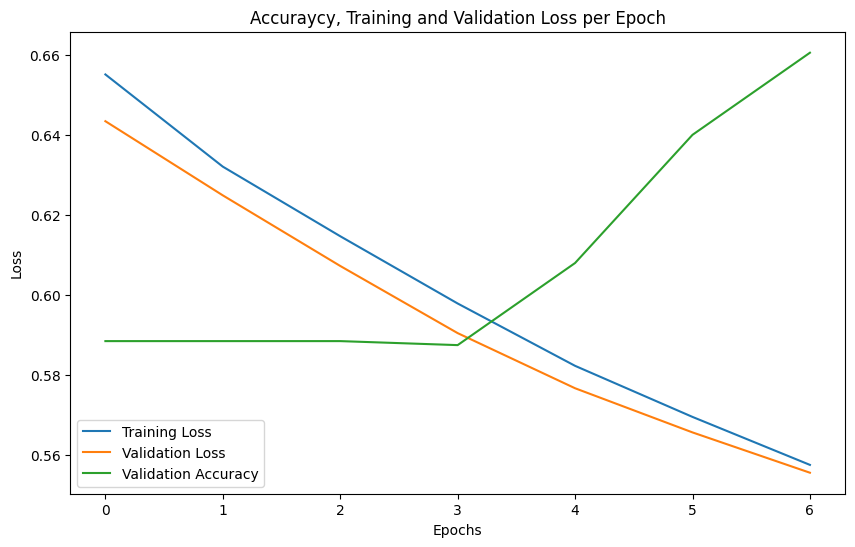

In [18]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_test_losses, label='Validation Loss')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuraycy, Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## Prediction on test data

In [19]:
## Load model
m_state_dict = torch.load('model/checkpoint.pt', weights_only=False)
new_model = CNNModel()
new_model = new_model.to('cuda')
new_model.load_state_dict(m_state_dict)

<All keys matched successfully>

Generating Predictions: 100%|██████████| 1796/1796 [05:06<00:00,  5.86batch/s]


Submission CSV generated: 'submission2.csv'


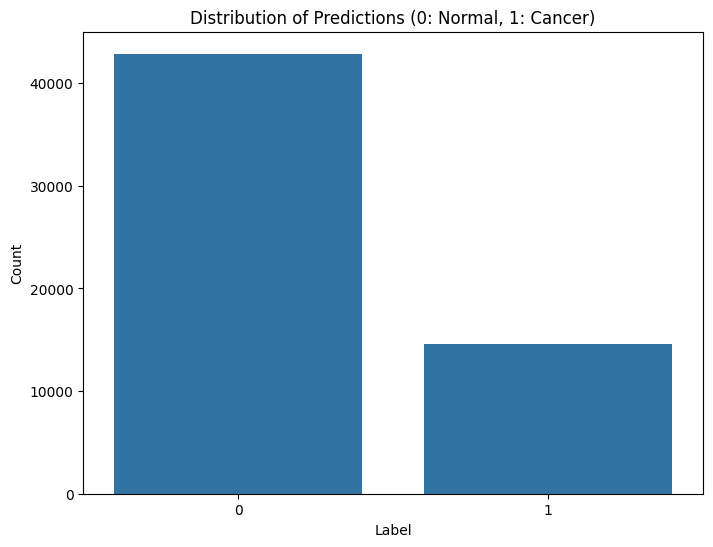

In [20]:
def create_submission():
    new_model.eval()
    image_ids = []
    predictions = []
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="Generating Predictions", unit="batch"):
            images = images.to(device)
            
            outputs = new_model(images)
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).int().cpu().numpy().flatten()
            filenames = [os.path.splitext(filename)[0] for filename in filenames]
            image_ids.extend(filenames)
            predictions.extend(preds)
    
    # Generate submission CSV
    submission_df = pd.DataFrame({
        'id': image_ids,
        'Label': predictions  # 0 for normal, 1 for cancer
    })
    
    submission_df['Label'] = submission_df['Label'].astype(int)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission CSV generated: 'submission.csv'")

    # Plot distribution of predictions
    plt.figure(figsize=(8, 6))
    sns.countplot(x=submission_df['Label'])
    plt.title('Distribution of Predictions (0: Normal, 1: Cancer)')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

create_submission()

# Results and Analysis


### 1. **Loss Reduction Analysis**:
   - **Training Loss**: The training loss decreases consistently from 0.6551 in Epoch 1 to 0.5576 in Epoch 7. This trend indicates that the model is progressively learning to minimize errors on the training data, showing effective optimization.
   - **Validation Loss**: The validation loss also decreases from 0.6434 to 0.5556 over the same period. The close alignment between training and validation loss suggests that the model is not overfitting at this stage. Since both losses are declining similarly, the model is generalizing well to the validation data.

### 2. **Accuracy Analysis**:
   - **Initial Accuracy (Epoch 1)**: The validation accuracy starts at 58.85%, which is only slightly better than random guessing for a binary classification problem. This indicates that the model had limited knowledge of the data's underlying patterns at the beginning.
   - **Steady Improvement**: By Epoch 7, validation accuracy has reached 66.05%. The consistent improvement suggests that the model is learning and capturing more relevant features with each epoch.
   - **Plateau Concern**: While there’s a positive trend in accuracy, the improvement from Epoch 5 to Epoch 7 is slower than earlier epochs. This might suggest that accuracy could plateau soon, potentially requiring adjustments, such as increasing training epochs, tuning the learning rate, or modifying other hyperparameters to drive further improvement.

### 3. **Model Generalization**:
   - The similar loss values and trends across both training and validation indicate that the model has not overfitted, which is often a risk in machine learning. Overfitting would be apparent if the training loss continued to decrease while the validation loss began to increase.
   - The gradual improvements in both loss and accuracy imply that the model is generalizing well to the validation set, capturing patterns that apply to unseen data.

### 4. **Potential Areas for Improvement**:
   - **Additional Epochs**: Since the model shows continuous improvement in both loss and accuracy, additional epochs may help it further refine its predictions. However, it's essential to monitor for any signs of overfitting.
   - **Learning Rate Adjustment**: The slow accuracy increase suggests that the learning rate might be low. A slight increase in the learning rate could potentially accelerate convergence, allowing the model to capture data patterns more effectively in fewer epochs.
   - **Data Augmentation or Regularization**: To enhance generalization and mitigate future overfitting risks, implementing data augmentation or regularization methods like dropout could help. While there is no current overfitting, these techniques might further strengthen the model's robustness.

### 5. **Validation Set Analysis**:
   - The model’s validation accuracy remains relatively low (66.05%), which may suggest some complexity in the data. Ensuring that the validation set is balanced and representative of the overall data distribution could help the model generalize better.
   - It could also be beneficial to examine the model's performance on individual classes to determine if there is a class imbalance issue. If one class is underrepresented, it could skew the results and affect generalization.



# Conclusion

Overall, the model shows consistent improvement with training, decreasing both training and validation losses while increasing validation accuracy. This indicates effective learning without signs of overfitting at this stage. However, the relatively low accuracy suggests that further tuning and additional epochs may be necessary to reach higher performance levels. Increasing the number of epochs seem to be the most productive changes. The point of diminishing returns for increasing number of epochs might not have been reached yet. Monitoring accuracy trends in subsequent epochs will help determine the need for more advanced techniques such as learning rate adjustments, and additional data augmentation.

# References

[1] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/